# 2026 Land-Doig MIP Competition Tutorial: Local Search on GPU

Christian Tjandraatmadja (ctjandra@google.com) and the 2026 Land-Doig MIP
Competition Committee

*Last updated: Dec 17, 2025*

--------------------------------------------------------------------------------

# Part 3: A GPU implementation of feasibility jump via JAX

This tutorial continues from Parts 1 and 2, which can be found in the [MIP competition website](https://www.mixedinteger.org/2026/competition). If you have not looked at them, please start from there.

In Part 3, we will write a GPU implementation of feasibility jump using [JAX](https://github.com/jax-ml/jax).

JAX is a library that can transform array-based function computation into GPU code. It essentially traces Python code to build a computation graph, which is then compiled to optimize that graph for GPU. It is commonly used for machine learning applications as it supports automatic differentiation of functions, but we will not be using that in this tutorial. Another popular alternative to JAX is PyTorch; this tutorial covers JAX purely due to the author's familiarity and readers might want to consider trade-offs themselves.

While this could be considered a higher-level library than Numba used in Part 2, it is also one that has different goals: in particular, its focus is on building a computation graph that represents a function to be evaluated (or differentiated over) later, rather than performing computation. The result is that the code looks more like building a model of a function instead of writing typical imperative code, e.g. instead of having a while loop or conditionals, we call a JAX function that results in a node in the computation graph that represents a while loop or a conditional. This makes it both simpler in certain ways and more restricted and complicated in other ways.

Make sure that you are running a GPU runtime with the cell below.

In [ ]:
# This shows GPU stats to ensure that a GPU is available in the Colab runtime.
# If you get an error here, then you likely need to switch your runtime to GPU.
!nvidia-smi

import jax
assert jax.devices()[0].platform == 'gpu'

# Initial setup and utility functions

These hidden cells need to be run first for the tutorial. These same cells appear on all parts. They contain imports and some
utility functions that will be useful later in the tutorial (e.g. plotting).
This is not too important for the tutorial itself and you can run this cell
without looking, though you may want to take a quick glance at the imports that
we will be using.

This includes the IPInstance data structure that was more explicit in Part 1.

In [2]:
import functools
import dataclasses
from typing import NamedTuple
import math

# Numba imports.
# Tip: If you need to debug Numba, uncomment below to use the CUDA simulator.
# https://numba.pydata.org/numba-doc/dev/cuda/simulator.html
# import os
# os.environ['NUMBA_ENABLE_CUDASIM'] = '1'
from numba import cuda, float64, int32

# JAX imports.
import jax
from jax.experimental import sparse
import jax.numpy as jnp

import matplotlib.pyplot as plt
import numpy as np
import scipy  # For sparse matrices.

In [3]:
@dataclasses.dataclass
class IPInstance:
  """Data structure to store a (pure) Integer Programming instance.

    minimize c^T x
      Ax <= b
      var_lb <= x <= var_ub
            x integer

  All vectors are stored as dense numpy vectors. The matrix A is stored as
  a sparse matrix in compressed sparse row (CSR) format.
  """

  c: np.ndarray
  A: scipy.sparse.csr_matrix
  b: np.ndarray
  var_lb: np.ndarray
  var_ub: np.ndarray

SIMPLE_IP = IPInstance(
    c=np.array([-1, -1]),
    A=scipy.sparse.csr_matrix(np.array([[-1, -2.5], [1, 2.5], [-3, 1], [1, 0]])),
    b=np.array([-3.5, 12, 0, 2.5]),
    var_lb=np.array([0, 0]),
    var_ub=np.array([3, 5]),
)

In [4]:
def initialize_solution(instance: IPInstance) -> np.ndarray:
  """Return the zero point, projected to variable bounds if outside them."""
  init_x = np.zeros(instance.A.shape[1])
  init_x = np.maximum(init_x, instance.var_lb)
  init_x = np.minimum(init_x, instance.var_ub)
  return init_x


def extend_A_b_with_objective_constraint(
    instance: IPInstance
) -> tuple[scipy.sparse.spmatrix, np.ndarray]:
  """Returns A and b with an additional row for objective constraint."""
  c_sparse = scipy.sparse.csr_matrix(instance.c)
  A_ext = scipy.sparse.vstack((instance.A, c_sparse), format='csr')
  b_ext = np.append(instance.b, np.inf)
  return A_ext, b_ext


# The right-hand side of objective constraint will be the best primal bound,
# minus this value. This emulates a strict inequality, though in this case it
# does not need to be necessarily small if we want to incentivize larger jumps.
OBJECTIVE_PUSH_VALUE = 1e-3

# Absolute tolerance for feasibility.
FEASIBILITY_TOLERANCE = 1e-6

# JAX implementation

For our JAX implementation, we implement a **(semi-)sparse version using padding and batching**. We only implement one variation in this part.

Unlike the Numba implementations in Part 2, we no longer write kernels. Instead, we can think of this as composing one big function that runs our heuristic, which makes it closer to our numpy implementation in Part 1. There is an experimental extension to JAX called [Pallas](https://docs.jax.dev/en/latest/pallas/index.html) that allows users to write kernels, but this is out of scope of this tutorial.

Like Numba, JAX is also just-in-time compiled, which is when the computation graph is constructed. However, a key difference is that compilation in JAX assumes static shapes, i.e. it is compiled specifically for given dimensions. This does mean that unlike Numba, for every new MIP instance with different sizes, JAX performs recompilation.

## Sparsity, static shapes, and padding

A challenge with dealing with sparsity in JAX is that it works with static shapes, with each dimension having the same length. In particular, JAX needs to know the shapes in advance as it compiles the function with those shapes. This makes it tricky for our case with columns with different numbers of nonzeros.

A common approach for dealing with jagged arrays in JAX (though not necessarily the most effective) is to **pad data with zeros so that all sub-arrays have the same shape**, and use masking to discard irrelevant computation. This makes the implementation look closer to dense computations, as we process entire multi-dimensional arrays. We do pay the cost of performing computation over the padding values.

In our case, where we are processing nonzeros in columns, what we get is reducing the size of the matrix from the number of rows to the maximum number of nonzeros in a column. For example:
```
col. 1: [1 0 2 0 3 1 0]   becomes  [1 2 3 1]
col. 2: [0 0 0 4 0 0 2]    ---->   [4 2 0 0] <-- zero is padding
```
with some more data to keep track of which rows each element comes from. This can be great if all columns have few nonzeros -- which can often occur in practical MIP instances -- but having a single dense column can destroy our sparsity.

In our tutorial example, we deal with this issue by splitting columns into batches/buckets based on their numbers of nonzeros. For simplicity, in this tutorial we will have the user specify the size bucketing; in practice, one could write a heuristic to decide. We intend to process each batch in sequence and not in parallel, which is why the number of batches cannot be too large.

* **Example:** If we have columns with 6, 2, 10, 3, 3, 12 nonzeros, we can specify a bucket of size 6 and another of size 12. Then, we have a batch with the columns with nonzeros [2, 3, 3, 6], and another batch with [6, 10, 12]. The former is padded up to 6 and the latter is padded up to 12. Our algorithm will process the first batch and then the second one in sequence, but still parallelizing over the columns in each batch.

There may be better ways to deal with sparsity in this case -- e.g. possibly with segmented operations -- however, we have not dug deeper and we will leave it outside the scope of the tutorial.

*Note on performance of bucketing:* In the benchmarks at the end of the tutorial, we find that bucketing helps when conditions are particularly favorable for bucketing, but it is not clear if it helps for general MIP instances as it has a relatively large overhead. That said, this can be controlled with how bucketing is performed (e.g. we can always put all columns in one bucket). Your mileage may vary.

## Implementation

It is convenient to first define what data we will work with. As discussed above, we will use batches of columns, so we define a data structure for that.

In [5]:
class SparseColBatch(NamedTuple):
  """Batch of `batch_size` columns, padded to a fixed `max_nnz` length."""
  # data[k][t] is a nonzero from column col_indices[k] and row row_indices[k][t]
  data: jax.Array           # Shape: (batch_size, max_nnz)
  row_indices: jax.Array    # Shape: (batch_size, max_nnz)
  col_indices: jax.Array    # Shape: (batch_size,)
  # padding_mask[k][t] is True if data[k][t] is real, or False if it is padding.
  padding_mask: jax.Array   # Shape: (batch_size, max_nnz)

We now move on to the simpler `compute_critical_deltas` and `compute_violations` functions. Note that they look similar to their corresponding numpy versions from Part 1, with exceptions on the syntax and the handling of the batch of columns. In particular, these are all JAX data structures instead of numpy arrays. JAX has its own version of numpy, `jax.numpy`, which we imported as `jnp`. Furthermore, unlike numpy, all JAX arrays are immutable.

In [6]:
def compute_critical_deltas_jax(
    col_batch: SparseColBatch, residuals: jax.Array
) -> jax.Array:
  """Compute critical deltas for each batch of columns from A.

    d_ij = floor(r_i / A_ij)  if A_ij > 0
           ceil(r_i / A_ij)   if A_ij < 0
  """
  # Gather residuals corresponding to the nonzero entries. This has shape
  # (batch_size, max_nnz).
  col_residuals = residuals[col_batch.row_indices]

  # Replace zeros by one to avoid division by zero errors. This is ok, since
  # we zero out the padded entries below.
  safe_A = jnp.where(col_batch.data == 0, 1.0, col_batch.data)
  ratio_matrix = col_residuals / safe_A

  # Take floor or ceiling depending on sign of A. The only zero values we have
  # in each column are paddings, and their critical deltas will be zero.
  floor_vals = jnp.floor(ratio_matrix)
  ceil_vals = jnp.ceil(ratio_matrix)
  critical_deltas = jnp.where(col_batch.data < 0, ceil_vals, 0.0)
  critical_deltas = jnp.where(col_batch.data > 0, floor_vals, critical_deltas)

  return critical_deltas


def compute_violations_jax(
    deltas: jax.Array,
    A_col_vals: jax.Array,
    A_col_rows: jax.Array,
    critical_deltas_col: jax.Array,
    mask_col: jax.Array,
    weights: jax.Array,
) -> jax.Array:
  """Computes the violation function for all `deltas` for a given column."""
  # Violation function:
  #   sum_i max(0, sign(A_col[i]) * w[i] * (deltas - cd_col[i]))

  # Gather weights for the rows involved in this column.
  col_weights = weights[A_col_rows]

  # The dimensions in this implementation are swapped compared to Part 1 since
  # we have implictly transposed the data by working with batches of columns,
  # i.e. the batch dimension is the first dimension.
  terms = (
      jnp.sign(A_col_vals)[None, :]
      * col_weights[None, :]
      * (deltas[:, None] - critical_deltas_col[None, :])
  )
  # Terms coming from padded entries are zeroed out to exclude from sum.
  terms = jnp.where(mask_col[None, :], terms, 0.0)
  all_violations = jnp.maximum(0, terms)
  return jnp.sum(all_violations, axis=1)

We now move on to `compute_best_deltas_and_scores`, which computes deltas and scores for a single batch of columns.

This illustrates a useful JAX feature: vectorizing maps (`vmap`). In this example, we write a function that computes the best delta and score of a column, `compute_deltas_and_scores_col`. We then use vmap to tell JAX to apply this function in parallel to all columns in the batch.

In [7]:
def compute_best_deltas_and_scores_jax(
    batch: SparseColBatch,
    batch_critical_deltas: jax.Array,
    weights: jax.Array,
    batch_delta_lb: jax.Array,
    batch_delta_ub: jax.Array,
) -> tuple[jax.Array, jax.Array, jax.Array]:
  """Computes deltas and scores for all columns in a batch.

  All arguments above except for `weights` are only for the columns in batch,
  i.e., have the same batch size in the first dimension.
  """
  # Define a function computing deltas and scores for a single column. We use
  # vmap to apply this function to all columns in the batch.
  def compute_deltas_and_scores_col(
      A_col_vals,
      A_col_row_inds,
      padding_mask,
      critical_deltas_col,
      delta_lb,
      delta_ub,
  ):
    # Collect critical deltas in column j within bounds, including bounds and
    # zero.
    delta_candidates_col = jnp.concatenate(
        [critical_deltas_col, jnp.array([delta_lb, delta_ub, 0.0])]
    )

    # Compute violations for the column.
    violations = compute_violations_jax(
        delta_candidates_col,
        A_col_vals,
        A_col_row_inds,
        critical_deltas_col,
        padding_mask,
        weights,
    )

    # Treat deltas outside bounds or padding as inf, so that they are ignored.
    ext_padding_mask = jnp.concatenate(
        [padding_mask, jnp.array([True, True, True])]
    )
    valid_mask = (
        (delta_candidates_col >= delta_lb)
        & (delta_candidates_col <= delta_ub)
        & ext_padding_mask
    )
    violations = jnp.where(valid_mask, violations, jnp.inf)

    # Find delta that minimizes violation, and on ties, take closest to zero.
    min_violation = jnp.min(violations)
    abs_deltas_with_min_violation = jnp.where(
        violations == min_violation, jnp.abs(delta_candidates_col), jnp.inf
    )
    best_idx = jnp.argmin(abs_deltas_with_min_violation)
    selected_delta = delta_candidates_col[best_idx]

    # Compute score. Recall the zero delta is in the last element.
    violation_at_zero = violations[-1]
    score = violation_at_zero - min_violation

    return selected_delta, score

  # Vectorize over the batch of columns. `in_axes` determines the axis for
  # which we want to map the function for each argument. In this case, we map
  # over the batch dimension (first one) for all arguments.
  best_deltas, scores = jax.vmap(
      compute_deltas_and_scores_col, in_axes=(0, 0, 0, 0, 0, 0)
  )(
      batch.data,
      batch.row_indices,
      batch.padding_mask,
      batch_critical_deltas,
      batch_delta_lb,
      batch_delta_ub,
  )

  return best_deltas, scores

Finally, we write the main loop, which looks similar to the ones in Part 1.

There are various differences in that we need to call specific JAX functions: for example, instead of writing a typical for loop, we call a JAX function to create the for loop, `jax.lax.while_loop`, passing the condition and body of the loop. In particular, because JAX must build the computation graph in advance with static shapes, we cannot use operations that output dynamic shapes that depend on data, which makes it tricky to do some otherwise simple operations such as finding the right column in batches to update residuals.

We also create a LoopState mostly for organization.


In [8]:
# Simple data structure to track loop variables.
class LoopState(NamedTuple):
  x: jax.Array
  w: jax.Array
  iter_num: int
  # Keep track of when the solution changes for the stopping condition.
  solution_changed: bool
  # Store b - Ax, which is incrementally updated.
  residuals: jax.Array
  # Keep track of the best solution found so far.
  best_feasible_obj_val: float
  best_feasible_x: jax.Array


# static_argnames specifies which args are constant at compile-time. If these
# change, or if the shape of the arguments change, the function needs to be
# recompiled.
@functools.partial(jax.jit, static_argnames=('max_num_steps', 'print_progress'))
def run_feasibility_jump_loop_jax(
    init_state: LoopState,
    col_batches: list[SparseColBatch],
    c: jax.Array,
    var_lb: jax.Array,
    var_ub: jax.Array,
    max_num_steps: int,
    print_progress: bool = True,
):
  # Define loop condition.
  def while_cond_fn(state: LoopState) -> bool:
    return (state.iter_num < max_num_steps) & state.solution_changed

  # Define a single step of the optimization loop.
  def step_fn(state: LoopState) -> LoopState:
    (x, weights, i, _, residuals, best_feas_obj_val, best_feas_x) = state

    # Ensure that residuals considers objective constraint slightly below the
    # best objective value. We recompute from scratch for simplicity.
    pushed_obj_rhs = best_feas_obj_val - OBJECTIVE_PUSH_VALUE
    curr_obj_val = jnp.dot(c, x)
    residuals = residuals.at[-1].set(pushed_obj_rhs - curr_obj_val)

    best_score = -jnp.inf
    best_delta = 0.0
    selected_var = -1

    # We compute each batch sequentially. JAX unrolls standard Python for loops.
    for col_batch in col_batches:

      # Compute critical deltas for this batch of columns.
      batch_critical_deltas = compute_critical_deltas_jax(col_batch, residuals)

      # Compute violations, scores, and corresponding deltas. Make sure that we
      # collect the bounds only for the columns in the batch.
      col_inds = col_batch.col_indices
      batch_delta_lb = var_lb[col_inds] - x[col_inds]
      batch_delta_ub = var_ub[col_inds] - x[col_inds]
      best_deltas, scores = compute_best_deltas_and_scores_jax(
          col_batch,
          batch_critical_deltas,
          weights,
          batch_delta_lb,
          batch_delta_ub,
      )

      # Select the variable with the highest score in the batch.
      batch_selected_var = jnp.argmax(scores)
      batch_best_score = scores[batch_selected_var]

      # Update global best if this batch has better score. Note the use of JAX
      # functions even for simple conditional operations.
      is_better = batch_best_score > best_score
      best_score = jnp.where(is_better, batch_best_score, best_score)
      best_delta = jnp.where(
          is_better, best_deltas[batch_selected_var], best_delta
      )
      selected_var = jnp.where(
          is_better, col_inds[batch_selected_var], selected_var
      )

    # Update solution.
    new_x = x.at[selected_var].add(best_delta)
    new_obj_val = jnp.dot(c, new_x)

    # Update residual vector. Since residuals are b - Ax, we subtract A * delta.
    # Updating the residual is nontrivial because our matrix A is in batches.
    # We could pass a copy of A which sacrifices memory, but here, we recover
    # the column from batches. This is messy and less efficient however.
    for col_batch in col_batches:
      # Get the index in the batch corresponding to selected_var. Unfortunately,
      # this is not too clean under JAX restrictions. One way is to build a bool
      # array and take the index of the first True value using jnp.argmax.
      matches_col = col_batch.col_indices == selected_var
      idx = jnp.argmax(matches_col)
      col_found = matches_col[idx]

      # Collect the paired arrays of values and row indices of the column and
      # update residuals. We use jax.lax.cond for skipping the computation if
      # the column is not found. Note that even conditionals are operations:
      # it must return an object of the same shape whether true or false.
      def update_residuals_fn(curr_residuals):
        col_values = col_batch.data[idx]
        col_row_indices = col_batch.row_indices[idx]
        return curr_residuals.at[col_row_indices].add(-col_values * best_delta)

      residuals = jax.lax.cond(
          col_found, update_residuals_fn, lambda x: x, residuals
      )

    # Compute bool vector of violated constraints, via residuals (b - Ax < 0).
    # If the current solution is feasible, store it. Note that due to the
    # objective constraint, feasibility here also implies objective improvement.
    violated_constraints = residuals < -FEASIBILITY_TOLERANCE
    is_feasible = ~jnp.any(violated_constraints)
    best_feas_obj_val = jnp.where(is_feasible, new_obj_val, best_feas_obj_val)
    best_feas_x = jnp.where(is_feasible, new_x, best_feas_x)

    # Update weights with simple weight update from feasibility jump paper:
    # increase weight by one for all currently violated constraints.
    new_weights = weights + violated_constraints

    solution_changed = best_delta != 0

    if print_progress:
      jax.debug.print('=== Iteration {} ===', i + 1, ordered=True)

      # In JAX JIT-compiled code, ifs are ok for static variables (e.g. in
      # static_argnames). To check best_delta below, we use a JAX operation so
      # that we can tell JAX to create a computational graph with both branches.
      def print_update():
        jax.debug.print(
            'Update: x[{}] = x[{}] + {}',
            selected_var,
            selected_var,
            best_delta,
            ordered=True,
        )
        jax.debug.print(
            '  New solution: {}, obj_val = {}', new_x, new_obj_val, ordered=True
        )
        jax.debug.print('  New weights: {}', new_weights, ordered=True)

      def print_no_update():
        jax.debug.print(
            'No variable update. Cannot continue. Done.', ordered=True
        )

      jax.lax.cond(best_delta != 0, print_update, print_no_update)
      jax.debug.print(
          '  Best feasible solution: {}, obj_val = {}\n',
          best_feas_x,
          best_feas_obj_val,
          ordered=True,
      )

    return LoopState(
        x=new_x,
        w=new_weights,
        iter_num=i + 1,
        solution_changed=solution_changed,
        residuals=residuals,
        best_feasible_obj_val=best_feas_obj_val,
        best_feasible_x=best_feas_x,
    )

  # Execute loop. Note that, if properly configured, this runs entirely on GPU.
  final_state = jax.lax.while_loop(while_cond_fn, step_fn, init_state)

  return final_state.x

The last ingredient that we are missing is initializing the heuristic and preparing the batches, which will be done on CPU before running the heuristic itself on GPU. These are perhaps less interesting for the tutorial: the former is the same as in previous parts, and the latter is simply identifying the columns with number of nonzeros corresponding to each bucket.

As previously noted, for simplicity we will assume the user will provide a list of "maximum numbers of nonzeros" for each batch.

In [9]:
def init_heuristic_jax(
    instance: IPInstance, init_x: np.ndarray, print_progress: bool = True
) -> tuple[LoopState, sparse.BCSR]:
  """Initializes data structures for the heuristic (on CPU)."""

  init_x = jnp.asarray(init_x)

  # We add c^T x <= val as an additional constraint to push the objective.
  # We initialize val with inf, and we constrain when we first hit feasibility.
  A_ext, b_ext = extend_A_b_with_objective_constraint(instance)
  A_ext = sparse.BCSR.from_scipy_sparse(A_ext)
  b_ext = jnp.asarray(b_ext)

  # Initialize weights.
  init_weights = jnp.ones(A_ext.shape[0])

  # Initialize residuals. We do a sparse matrix-vector computation only once.
  init_residuals = b_ext - A_ext @ init_x

  # If feasible, take objective value to be the best one found so far.
  # We do not need to update the residuals for the objective value constraint
  # as we do it in the beginning of the loop.
  if jnp.all(init_residuals >= 0):
    best_feasible_obj_val = jnp.dot(instance.c, init_x)
  else:
    best_feasible_obj_val = jnp.inf

  init_state = LoopState(
      x=init_x,
      w=init_weights,
      iter_num=0,
      solution_changed=True,
      residuals=init_residuals,
      best_feasible_obj_val=best_feasible_obj_val,
      best_feasible_x=init_x,
  )

  if print_progress:
    obj_val = jnp.dot(instance.c, init_state.x)
    print('Starting feasibility jump from initial solution:')
    print(f'  {init_state.x}, obj_val = {obj_val}\n')

  return init_state, A_ext


# For simplicity, our bucketing strategy is user-defined. One could write a
# heuristic to decide how bucketing will be performed.
def prepare_batches_of_sparse_cols(
    A: scipy.sparse.csc_matrix, bucket_config: list[int] = None
) -> tuple[list[SparseColBatch], np.ndarray]:
  assert scipy.sparse.isspmatrix_csc(A)

  _, num_cols = A.shape

  # np.diff takes the difference between each consecutive pair, which in this
  # case is the number of nonzeros per column.
  col_nnz = np.diff(A.indptr)
  max_col_nnz = int(np.max(col_nnz))

  batches = []

  # If None, we use a single bucket.
  if bucket_config is None:
    bucket_config = [max_col_nnz]

  buckets = sorted(bucket_config)

  # Ensure we have a bucket for the column with the largest number of nonzeros.
  if buckets[-1] < max_col_nnz:
    buckets.append(max_col_nnz)

  # Assign columns to buckets. For example, if a column has 10 nonzeros, it goes
  # into the smallest bucket of size at least 10.
  col_indices = np.arange(num_cols)
  available_cols_mask = np.ones(num_cols, dtype=bool)

  for max_col_nnz in buckets:
    # Collect unprocessed columns that fit into the current bucket.
    bucket_cols_mask = (col_nnz <= max_col_nnz) & available_cols_mask
    if not np.any(bucket_cols_mask):
      continue

    batch_cols = col_indices[bucket_cols_mask]

    # Remove these columns from consideration in future iterations.
    available_cols_mask[bucket_cols_mask] = False

    # Prepare batched arrays. Padding is done implicitly by starting with zeros
    # and copying columns to the beginning of the arrays.
    count = len(batch_cols)
    batch_vals = np.zeros((count, max_col_nnz), dtype=np.float32)
    batch_rows = np.zeros((count, max_col_nnz), dtype=np.int32)
    batch_mask = np.zeros((count, max_col_nnz), dtype=bool)
    for i, col_idx in enumerate(batch_cols):
      # Recall that in the CSC format, indptr stores the indices where each
      # column starts and ends.
      start = A.indptr[col_idx]
      end = A.indptr[col_idx + 1]
      length = end - start
      batch_vals[i, :length] = A.data[start:end]
      batch_rows[i, :length] = A.indices[start:end]
      batch_mask[i, :length] = True

    # Add this batch to our list of batches.
    batches.append(
        SparseColBatch(
            data=jnp.array(batch_vals),
            row_indices=jnp.array(batch_rows),
            padding_mask=jnp.array(batch_mask),
            col_indices=jnp.array(batch_cols),
        )
    )

  return batches


def run_feasibility_jump_jax(
    instance: IPInstance,
    init_x: np.ndarray,
    max_num_steps: int,
    bucket_config: list[int],
    print_progress: bool = True,
) -> jnp.ndarray:
  # Initialize data on CPU.
  init_state, A_ext = init_heuristic_jax(instance, init_x, print_progress)

  # On CPU, prepare batches of sparse columns via bucketing. Each batch will
  # have the same shape, with extra rows padded with zeros.
  c_sparse = scipy.sparse.csr_matrix(instance.c)
  A_ext_scipy = scipy.sparse.vstack([instance.A, c_sparse])
  A_csc = A_ext_scipy.tocsc()
  col_batches = prepare_batches_of_sparse_cols(A_csc, bucket_config)
  c = jnp.array(instance.c)
  var_lb = jnp.array(instance.var_lb)
  var_ub = jnp.array(instance.var_ub)

  # Ensure that data is put on GPU.
  init_state_dev = jax.device_put(init_state)
  col_batches_dev = jax.device_put(col_batches)
  c_dev = jax.device_put(c)
  var_lb_dev = jax.device_put(var_lb)
  var_ub_dev = jax.device_put(var_ub)

  # Run feasibility jump loop on GPU.
  result = run_feasibility_jump_loop_jax(
      init_state_dev,
      col_batches_dev,
      c_dev,
      var_lb_dev,
      var_ub_dev,
      max_num_steps,
      print_progress,
  )
  return result


# Run heuristic for simple example

In [10]:
# Run feasibility jump for simple instance with JAX.
init_x = initialize_solution(SIMPLE_IP)
run_feasibility_jump_jax(SIMPLE_IP, init_x, max_num_steps=10, bucket_config=None)

Starting feasibility jump from initial solution:
  [0. 0.], obj_val = -0.0

=== Iteration 1 ===
Update: x[0] = x[0] + 2.0
  New solution: [2. 0.], obj_val = -2.0
  New weights: [2. 1. 1. 1. 1.]
  Best feasible solution: [0. 0.], obj_val = inf

=== Iteration 2 ===
Update: x[1] = x[1] + 1.0
  New solution: [2. 1.], obj_val = -3.0
  New weights: [2. 1. 1. 1. 1.]
  Best feasible solution: [2. 1.], obj_val = -3.0

=== Iteration 3 ===
Update: x[1] = x[1] + 1.0
  New solution: [2. 2.], obj_val = -4.0
  New weights: [2. 1. 1. 1. 1.]
  Best feasible solution: [2. 2.], obj_val = -4.0

=== Iteration 4 ===
Update: x[1] = x[1] + 1.0
  New solution: [2. 3.], obj_val = -5.0
  New weights: [2. 1. 1. 1. 1.]
  Best feasible solution: [2. 3.], obj_val = -5.0

=== Iteration 5 ===
Update: x[1] = x[1] + 1.0
  New solution: [2. 4.], obj_val = -6.0
  New weights: [2. 1. 1. 1. 1.]
  Best feasible solution: [2. 4.], obj_val = -6.0

=== Iteration 6 ===
No variable update. Cannot continue. Done.
  Best feasible s

Array([2., 4.], dtype=float32)

# Benchmarking setup

We use the same cutting stock instances as in Part 1, except that we change the maximum number of item types per pattern (which affects column density) to a randomly take from a given list instead of a fixed value. Furthermore, we copy the numpy CPU implementation in the following hidden cell for a comparison.

In [11]:
def generate_cutting_stock_instance(
    num_items: int,
    num_extra_patterns: int,
    max_item_types_per_pattern_vals: list[int] = (8,),
    max_bin_width: int = 400,
    seed: int = 1234,
) -> IPInstance:
  """Generates a random instance for a simple cutting stock problem.

  We consider a cutting stock problem where the patterns are fixed. For a
  description, see https://en.wikipedia.org/wiki/Cutting_stock_problem, except
  that we generate a random set of patterns to choose from.

    min sum(x)
        Ax >= b
         x >= 0, integer

  where variables x_j indicates that we use pattern j x_j times.

  To emulate some sparsity, we limit the number of item types in each pattern.
  This implies that the number of nonzeros per column is bounded by a range
  `max_item_types_per_pattern_range`.

  Args:
    num_items: Number of items in the cutting stock problem, corresponding to
      the number of constraints.
    num_extra_patterns: Number of patterns beyond singleton patterns. The total
      number of variables will be num_items + num_extra_patterns.
    max_item_types_per_pattern_range: Range for the maximum number of item types
      in each pattern. This bounds the number of nonzeros per column.
    seed: Seed for random number generator.

  Returns:
    An IPInstance corresponding to the generated instance.
  """
  np.random.seed(seed)

  min_item_width = 5
  max_item_width = 20
  min_demand = 5
  max_demand = 40

  # Generate widths and demands for each item.
  item_widths = np.random.randint(
      min_item_width, max_item_width + 1, size=num_items
  )
  item_demands = np.random.randint(min_demand, max_demand, size=num_items)

  # Add singleton patterns, each of which contains one item, for feasibility.
  singleton_patterns = np.eye(num_items, dtype=int)

  extra_patterns = []
  # Add random patterns by randomly adding items until capacity. We restrict to
  # a subset of item types per pattern, limited by `max_item_types_per_pattern`.
  for _ in range(num_extra_patterns):
    max_item_types_per_pattern = np.random.choice(
        max_item_types_per_pattern_vals
    )
    allowed_items = np.random.choice(
        num_items,
        size=min(max_item_types_per_pattern, num_items),
        replace=False,
    )
    # Generate a long random stream of items.
    min_width = item_widths[allowed_items].min()
    num_gen_items = int(max_bin_width / max(1, min_width)) + 1
    candidate_stream = np.random.choice(allowed_items, size=num_gen_items)

    # Cut off the stream at `max_bin_width`.
    cumulative_widths = np.cumsum(item_widths[candidate_stream])
    cutoff = np.searchsorted(cumulative_widths, max_bin_width, side='right')

    # Count the items in the array.
    pattern = np.bincount(candidate_stream[:cutoff], minlength=num_items)
    extra_patterns.append(pattern)

  # Shape is (num_vars (i.e. num_patterns), num_items).
  patterns = np.vstack([singleton_patterns, np.array(extra_patterns)])

  num_vars = len(patterns)

  # Construct constraint coefficient matrix A in sparse form.
  col_indices, row_indices = patterns.nonzero()
  data = -patterns[col_indices, row_indices]  # Negate since we use <=.
  A = scipy.sparse.csr_matrix(
      (data, (row_indices, col_indices)),
      shape=(patterns.shape[1], patterns.shape[0])
  )

  # Construct RHS, which are simply item demands (negated due to <=).
  rhs = -item_demands.astype(np.float64)

  # Objective function is to minimize total numbers of patterns used.
  obj_c = np.ones(num_vars, dtype=np.float64)

  # Define variable bounds. We assume problem is bounded.
  var_lb = np.zeros(num_vars, dtype=np.float64)
  var_ub = np.full(num_vars, 100, dtype=np.float64)

  return IPInstance(
      c=obj_c,
      A=A,
      b=rhs,
      var_lb=var_lb,
      var_ub=var_ub,
  )

In [12]:
# This is (mostly) a copy of the Part 1 implementation for comparison purposes.

def compute_critical_deltas_cpu_sparse(
    A: scipy.sparse.csc_matrix, residuals: np.ndarray
) -> scipy.sparse.csc_matrix:
  """Compute critical deltas for each nonzero A_ij.

    d_ij = floor(r_i / A_ij)  if A_ij > 0
           ceil(r_i / A_ij)   if A_ij < 0

  The result is a matrix of the same size as A. In this sparse version, we
  assume that we do not have zero entries in the nonzero data. Note that this
  is not guaranteed as a user can add them manually.
  """
  row_indices = A.indices
  # We make a hard assumption that A.data has no zeros.
  ratio_matrix = residuals[row_indices] / A.data
  critical_delta_data = np.select(
      [A.data > 0, A.data < 0],
      [np.floor(ratio_matrix), np.ceil(ratio_matrix)],
  )
  return scipy.sparse.csc_matrix(
      (critical_delta_data, A.indices, A.indptr), shape=A.shape
  )

def compute_violations_cpu_sparse(
    deltas: np.ndarray,
    A_col: np.ndarray,
    critical_deltas_col: np.ndarray,
    weights_col: np.ndarray,
) -> np.ndarray:
  """Computes the violation function for all `deltas` for a given column."""
  # Note that we do not need to pass the column index here as we are given only
  # the relevant column data directly.
  # Violation function:
  #   sum_i max(0, sign(A_col[i]) * w[i] * (deltas - cd_col[i]))
  terms = (
      np.sign(A_col)[:, None]
      * weights_col[:, None]
      * (deltas[None, :] - critical_deltas_col[:, None])
  )
  all_violations = np.maximum(0, terms)
  return np.sum(all_violations, axis=0)

def compute_best_deltas_and_scores_cpu_sparse(
    A: scipy.sparse.csc_matrix,
    critical_deltas: scipy.sparse.csc_matrix,
    weights: np.ndarray,
    delta_lb: np.ndarray,
    delta_ub: np.ndarray,
) -> tuple[np.ndarray, np.ndarray]:
  """Computes deltas and scores for all variables."""
  _, num_cols = A.shape
  best_deltas = []
  scores = []
  for j in range(num_cols):
    # Find pointers for the start and end of column j.
    start_ptr = A.indptr[j]
    end_ptr = A.indptr[j + 1]
    if start_ptr == end_ptr:
      continue  # Empty column.

    # Extract column data.
    row_indices = A.indices[start_ptr:end_ptr]
    A_col_vals = A.data[start_ptr:end_ptr]
    cd_col_vals = critical_deltas.data[start_ptr:end_ptr]
    weights_col = weights[row_indices]

    # Collect critical deltas in column j within bounds.
    deltas_j = cd_col_vals[
        (cd_col_vals >= delta_lb[j]) & (cd_col_vals <= delta_ub[j])
    ]
    # Include bounds and zero point to compute violation.
    deltas_j = np.append(deltas_j, [delta_lb[j], delta_ub[j], 0])

    # Compute violations for all critical deltas.
    violations = compute_violations_cpu_sparse(
        deltas_j, A_col_vals, cd_col_vals, weights_col
    )

    # Take delta with lowest violation, and as a tie-breaker, closest to zero.
    # np.lexsort returns the smallest index prioritizing args back-to-front.
    selected_index = np.lexsort((np.abs(deltas_j), violations))[0]
    best_deltas.append(deltas_j[selected_index])

    # Score is the violation at zero (added as last delta above) subtracted by
    # the minimum violation.
    score = violations[-1] - violations[selected_index]
    assert score >= 0
    scores.append(score)
  return best_deltas, scores

def run_feasibility_jump_cpu_sparse(
    instance: IPInstance,
    init_x: np.ndarray,
    max_num_steps: int,
    print_progress: bool = True,
) -> np.ndarray:
  x = init_x
  obj_val = np.dot(instance.c, x)
  best_feasible_obj_val = np.inf
  best_x = x

  # We assume that there will be no zero entries in the sparse representation.
  # This depends on construction, as a user might manually add zero entries.
  assert np.all(
      instance.A.data != 0
  ), 'Ensure that sparse entries in A do not include zero.'

  # Initialize weights to be all ones. Note that this includes the constraint
  # on the objective.
  weights = np.ones(shape=(instance.A.shape[0] + 1,))

  # Extend A and b by adding a constraint for the objective function. At first
  # we do not enforce any value for the objective.
  A_ext, b_ext = extend_A_b_with_objective_constraint(instance)

  # Initialize residuals.
  residuals = b_ext - A_ext @ x

  # Convert the matrix A to CSC format, which will be more convenient and
  # efficient as our computation is typically column-wise.
  A_ext = A_ext.tocsc()

  if print_progress:
    print('Starting feasibility jump from initial solution:')
    print(f'  {init_x}, obj_val = {obj_val}')
    print()

  # Main feasibility jump loop. At each step, we move one variable.
  for i in range(max_num_steps):
    # Ensure objective constraint is updated with best primal bound. Note that
    # we never use b directly in the algorithm, only implicitly via residuals.
    pushed_obj_rhs = best_feasible_obj_val - OBJECTIVE_PUSH_VALUE
    curr_obj_val = np.dot(instance.c, x)
    residuals[-1] = pushed_obj_rhs - curr_obj_val

    # Compute critical deltas.
    critical_deltas = compute_critical_deltas_cpu_sparse(A_ext, residuals)

    # Compute violations, scores, and corresponding deltas.
    delta_lb = instance.var_lb - x
    delta_ub = instance.var_ub - x
    best_deltas, scores = compute_best_deltas_and_scores_cpu_sparse(
        A_ext, critical_deltas, weights, delta_lb, delta_ub
    )

    # Select the variable with the highest score.
    selected_var = np.argmax(scores)
    best_delta = best_deltas[selected_var]
    new_x = x.copy()
    new_x[selected_var] += best_delta
    new_obj_val = np.dot(instance.c, new_x)

    # Update residual vector. Since residuals are b - Ax, we subtract A * delta.
    # In a real implementation, we might consider mitigating loss of precision.
    dense_col_j = A_ext[:, selected_var].toarray().ravel()
    residuals = residuals - dense_col_j * best_delta

    # Compute bool vector of violated constraints, via residuals (b - Ax < 0).
    # If the current solution is feasible, store it.
    violated_constraints = residuals < -FEASIBILITY_TOLERANCE
    is_feasible = ~np.any(violated_constraints)
    if is_feasible and new_obj_val < best_feasible_obj_val:
      best_feasible_obj_val = new_obj_val
      best_x = new_x

    # Update weights with simple weight update from feasibility jump paper:
    # increase weight by one for all currently violated constraints.
    new_weights = weights + violated_constraints

    # Print status.
    if print_progress:
      print(f'=== Iteration {i+1} ===')
      if best_delta != 0:
        print(f'Update: x[{selected_var}] = x[{selected_var}] + {best_delta}')
        print(f'  New solution: {new_x}, obj_val = {new_obj_val}')
        print(f'  New weights: {new_weights}')
      else:
        print('No variable update. Cannot continue. Done.')
        break
      print(
          f'  Best feasible solution: {best_x}, obj_val ='
          f' {best_feasible_obj_val}'
      )
      print()

    x = new_x
    weights = new_weights

  return x

# Benchmarking

We once again compare this implementation with the sparse CPU version, showing how GPU implementations can help. Then, we show that bucketing can help when the number of nonzeros is favorable to bucketing, though not so much in a less favorable situation given its overhead.

Benchmarking:   0%|          | 0/4 [00:00<?, ?it/s]

Instance generation time (trial=0, value=50): 0.008288s
JAX compilation time: 1.13
Instance generation time (trial=1, value=50): 0.003670s
Instance generation time (trial=2, value=50): 0.006667s
Instance generation time (trial=0, value=100): 0.015060s
JAX compilation time: 1.21
Instance generation time (trial=1, value=100): 0.006137s
Instance generation time (trial=2, value=100): 0.006648s
Instance generation time (trial=0, value=200): 0.018070s
JAX compilation time: 1.34
Instance generation time (trial=1, value=200): 0.019669s
Instance generation time (trial=2, value=200): 0.014567s
Instance generation time (trial=0, value=400): 0.033156s
JAX compilation time: 1.76
Instance generation time (trial=1, value=400): 0.052299s
Instance generation time (trial=2, value=400): 0.029490s


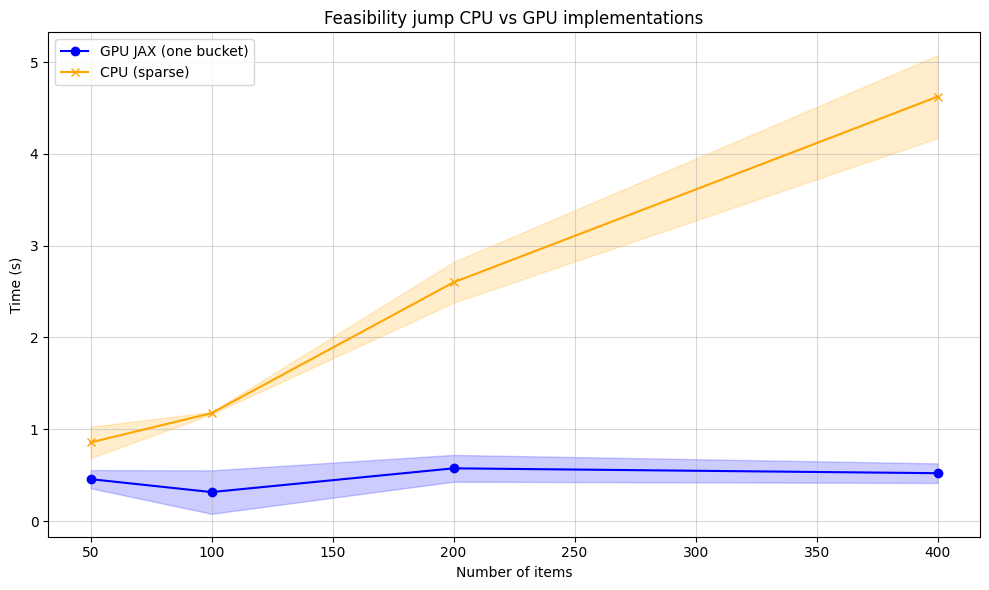

Benchmarking:   0%|          | 0/7 [00:00<?, ?it/s]

Instance generation time (trial=0, value=200): 0.045268s
JAX compilation time: 2.07
Instance generation time (trial=1, value=200): 0.020070s
Instance generation time (trial=2, value=200): 0.019656s
Instance generation time (trial=0, value=400): 0.047474s
JAX compilation time: 1.63
Instance generation time (trial=1, value=400): 0.044164s
Instance generation time (trial=2, value=400): 0.044380s
Instance generation time (trial=0, value=800): 0.111832s
JAX compilation time: 1.88
Instance generation time (trial=1, value=800): 0.100136s
Instance generation time (trial=2, value=800): 0.104060s
Instance generation time (trial=0, value=1600): 0.278346s
JAX compilation time: 1.65
Instance generation time (trial=1, value=1600): 0.284578s
Instance generation time (trial=2, value=1600): 0.288430s
Instance generation time (trial=0, value=3200): 0.776251s
JAX compilation time: 1.84
Instance generation time (trial=1, value=3200): 0.742587s
Instance generation time (trial=2, value=3200): 0.781484s
Inst

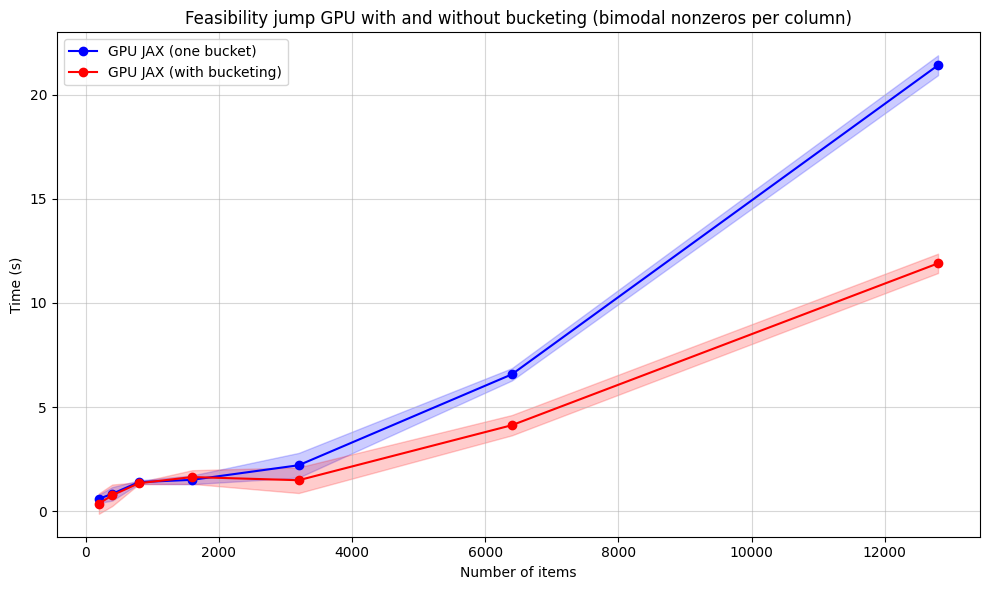

Benchmarking:   0%|          | 0/7 [00:00<?, ?it/s]

Instance generation time (trial=0, value=200): 0.059649s
JAX compilation time: 1.86
Instance generation time (trial=1, value=200): 0.026513s
Instance generation time (trial=2, value=200): 0.032764s
Instance generation time (trial=0, value=400): 0.070874s
JAX compilation time: 1.70
Instance generation time (trial=1, value=400): 0.061270s
Instance generation time (trial=2, value=400): 0.062229s
Instance generation time (trial=0, value=800): 0.169628s
JAX compilation time: 1.66
Instance generation time (trial=1, value=800): 0.257408s
Instance generation time (trial=2, value=800): 0.165338s
Instance generation time (trial=0, value=1600): 0.475553s
JAX compilation time: 1.67
Instance generation time (trial=1, value=1600): 0.479770s
Instance generation time (trial=2, value=1600): 0.464830s
Instance generation time (trial=0, value=3200): 1.578573s
JAX compilation time: 2.58
Instance generation time (trial=1, value=3200): 1.585692s
Instance generation time (trial=2, value=3200): 1.607312s
Inst

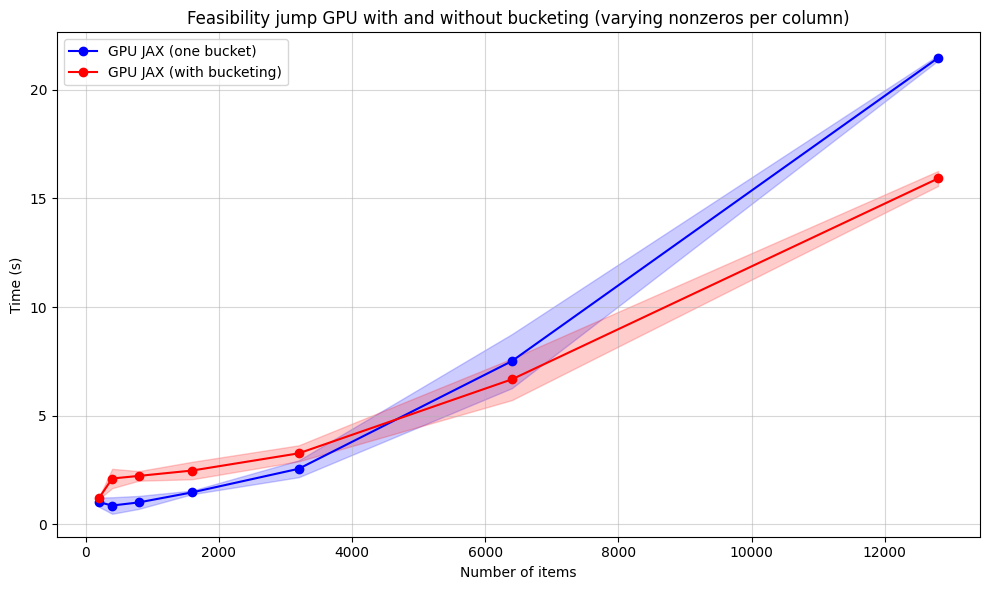

In [15]:
import gc
import time
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm


def benchmark_execution(func, force_recompile=False, using_jax=False, *args, **kwargs):
  """Runs a function for benchmarking."""
  start_time = time.perf_counter()
  if force_recompile:
    jax.clear_caches()
  solution = func(*args, **kwargs)
  if using_jax:
    jax.block_until_ready(solution)
  end_time = time.perf_counter()
  return end_time - start_time, solution


def run_benchmark(
    mode: str,
    values_to_test: list,
    fixed_param: int,
    num_trials: int = 3,
    max_steps: int = 200,
    num_extra_patterns_ratio: float = 1.0,
    max_bin_width: int = 400,
    seed_offset: int = 1234,
    run_bucketing: bool = True,
    run_cpu: bool = True,
    force_recompile: bool = True,
    v2_bucket_config: list[int] = None,
    instance_col_density_type: str = 'fixed', # 'fixed', 'bimodal', 'varying'
):
  assert instance_col_density_type in ('fixed', 'bimodal', 'varying')
  results = {
      'mode': mode,
      'values': values_to_test,
      'gpu_v1_mean': [],
      'gpu_v1_std': [],
      'gpu_v2_mean': [],
      'gpu_v2_std': [],
      'cpu_mean': [],
      'cpu_std': [],
  }

  for val in tqdm(values_to_test, desc='Benchmarking'):

    if mode == 'size':
      n_items = val
      max_types = min(fixed_param, n_items)
    elif mode == 'density':
      n_items = fixed_param
      max_types = min(val, n_items)
    else:
      raise ValueError("mode must be 'size' or 'density'")

    n_patterns = int(n_items * num_extra_patterns_ratio)

    gpu_v1_times = []
    gpu_v2_times = []
    cpu_times = []

    for i in range(num_trials):
      seed = seed_offset + (val * 100) + i

      start_time = time.perf_counter()
      if instance_col_density_type == 'bimodal':
        max_item_types_per_pattern_vals = (max_types, n_items)
      elif instance_col_density_type == 'varying':
        max_item_types_per_pattern_vals = range(max_types, n_items)
      else:
        max_item_types_per_pattern_vals = (max_types,)

      instance = generate_cutting_stock_instance(
          num_items=n_items,
          num_extra_patterns=n_patterns,
          max_item_types_per_pattern_vals=max_item_types_per_pattern_vals,
          max_bin_width=max_bin_width,
          seed=seed,
      )
      end_time = time.perf_counter()
      print(f"Instance generation time (trial={i}, value={val}): {end_time - start_time:2f}s")

      init_x = initialize_solution(instance)

      if not force_recompile and i == 0:
        init_x = initialize_solution(instance)
        start_time = time.perf_counter()
        jax.clear_caches()
        # Run a few steps to force compilation.
        run_feasibility_jump_jax(
            instance=instance,
            init_x=init_x.copy(),
            max_num_steps=5,
            print_progress=False,
            bucket_config=None,
        )
        end_time = time.perf_counter()
        print(f"JAX compilation time: {end_time - start_time:.2f}")

      t_gpu_v1, solution = benchmark_execution(
          run_feasibility_jump_jax,
          instance=instance,
          init_x=init_x.copy(),
          max_num_steps=max_steps,
          print_progress=False,
          force_recompile=force_recompile,
          using_jax=True,
          bucket_config=None,
      )
      gpu_v1_times.append(t_gpu_v1)

      if run_bucketing:
        t_gpu_v2, solution = benchmark_execution(
            run_feasibility_jump_jax,
            instance=instance,
            init_x=init_x.copy(),
            max_num_steps=max_steps,
            print_progress=False,
            force_recompile=force_recompile,
            using_jax=True,
            bucket_config=v2_bucket_config,
        )
        gpu_v2_times.append(t_gpu_v2)

      if run_cpu:
        t_cpu, solution = benchmark_execution(
            run_feasibility_jump_cpu_sparse,
            instance=instance,
            init_x=init_x.copy(),
            max_num_steps=max_steps,
            print_progress=False,
        )
        cpu_times.append(t_cpu)

    results['gpu_v1_mean'].append(np.mean(gpu_v1_times))
    results['gpu_v1_std'].append(np.std(gpu_v1_times))
    if run_bucketing:
      results['gpu_v2_mean'].append(np.mean(gpu_v2_times))
      results['gpu_v2_std'].append(np.std(gpu_v2_times))
    if run_cpu:
      results['cpu_mean'].append(np.mean(cpu_times))
      results['cpu_std'].append(np.std(cpu_times))

  return results


def plot_benchmark_results(res, title):
  vals = np.array(res['values'])
  mode = res['mode']

  g1_mean = np.array(res['gpu_v1_mean'])
  g1_std = np.array(res['gpu_v1_std'])
  g2_mean = np.array(res['gpu_v2_mean'])
  g2_std = np.array(res['gpu_v2_std'])
  c_mean = np.array(res['cpu_mean'])
  c_std = np.array(res['cpu_std'])

  plt.figure(figsize=(10, 6))

  plt.plot(vals, g1_mean, label='GPU JAX (one bucket)', marker='o', color='blue')
  plt.fill_between(
      vals, g1_mean - g1_std, g1_mean + g1_std, alpha=0.2, color='blue'
  )

  if g2_mean.size != 0:
    plt.plot(vals, g2_mean, label='GPU JAX (with bucketing)', marker='o', color='red')
    plt.fill_between(
        vals, g2_mean - g2_std, g2_mean + g2_std, alpha=0.2, color='red'
    )

  if c_mean.size != 0:
    plt.plot(vals, c_mean, label='CPU (sparse)', marker='x', color='orange')
    plt.fill_between(
        vals, c_mean - c_std, c_mean + c_std, alpha=0.2, color='orange'
    )

  plt.ylabel('Time (s)')
  plt.title(title)
  if mode == 'size':
    plt.xlabel('Number of items')
  else:
    plt.xlabel('Max item types per pattern')

  plt.legend()
  plt.grid(True, which='both', ls='-', alpha=0.5)
  plt.tight_layout()
  plt.show()


# Run a comparison with the CPU implementation. Keep in mind that the CPU
# implementation could be faster if implemented in a lower-level language.
results_size = run_benchmark(
    mode='size',
    values_to_test=[50, 100, 200, 400],
    fixed_param=8,  # fixed max_item_types_per_pattern
    run_cpu=True,
    run_bucketing=False,
    force_recompile=False,
)
plot_benchmark_results(
    results_size,
    title='Feasibility jump CPU vs GPU implementations'
)

# Run a comparison between the version with bucketing and without. With the
# parameter `instance_col_density_type='bimodal'`, we generate either very
# sparse or very dense columns in the instance. This heavily favors the
# bucketing case.
results_size = run_benchmark(
    mode='size',
    values_to_test=[200, 400, 800, 1600, 3200, 6400, 12800],
    fixed_param=8,  # smallest max_item_types_per_pattern
    max_bin_width=10000,  # large bin to allow denser columns
    run_cpu=False,
    run_bucketing=True,
    force_recompile=False,
    # Note that this is two buckets if there is at least one column with
    # more than max_types nonzeros, since we add the maximum.
    v2_bucket_config=(8,),
    instance_col_density_type='bimodal',
)
plot_benchmark_results(
    results_size,
    title='Feasibility jump GPU with and without bucketing (bimodal nonzeros per column)'
)

# With the parameter `instance_col_density_type='varying'`, we generate columns
# with number of nonzeros from 8 to fully dense.
results_size = run_benchmark(
    mode='size',
    values_to_test=[200, 400, 800, 1600, 3200, 6400, 12800],
    fixed_param=8,  # smallest max_item_types_per_pattern
    max_bin_width=10000,  # large bin to allow denser columns
    run_cpu=False,
    run_bucketing=True,
    force_recompile=False,
    v2_bucket_config=(64, 256, 1024),
    instance_col_density_type='varying',
)
plot_benchmark_results(
    results_size,
    title='Feasibility jump GPU with and without bucketing (varying nonzeros per column)'
)


This concludes the tutorial!